In [1]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import  Input,Conv2D, MaxPooling2D
from keras.layers import Activation, Dense,Rescaling, MultiHeadAttention,BatchNormalization, Reshape
from tensorflow.keras import activations
from keras.regularizers import l2
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten,Input, BatchNormalization, GlobalMaxPool1D,LSTM
from keras.models import Model
from tensorflow.keras.losses import sparse_categorical_crossentropy, categorical_crossentropy
import tensorflow_addons as tfa
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter
import os
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.utils import shuffle
from scipy.signal import savgol_filter
from scipy.interpolate import CubicSpline
from sklearn import preprocessing
import scipy.spatial as sp
from sklearn.decomposition import PCA
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import * 
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K
from scipy.stats import skew, kurtosis, iqr
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import r2_score, mean_squared_error
from numpy.linalg import norm
from scipy import interpolate
import librosa
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import Sequence
import librosa.display

import cv2

Image data shape:  (12, 256, 256, 3)
X_train shape:  (8, 256, 256, 3)
X_val shape:  (2, 256, 256, 3)
X_test shape:  (2, 256, 256, 3)
y_train shape:  (8, 3)
y_val shape:  (2, 3)
y_test shape:  (2, 3)
try number:  0
try number:  1
try number:  2
try number:  3
try number:  4
try number:  5
try number:  6
try number:  7
try number:  8
try number:  9
try number:  10
try number:  11
try number:  12
try number:  13
try number:  14
try number:  15
try number:  16
try number:  17
try number:  18
try number:  19
-----------------------------------------
Best accuracy:  1.0
------------------------------------------


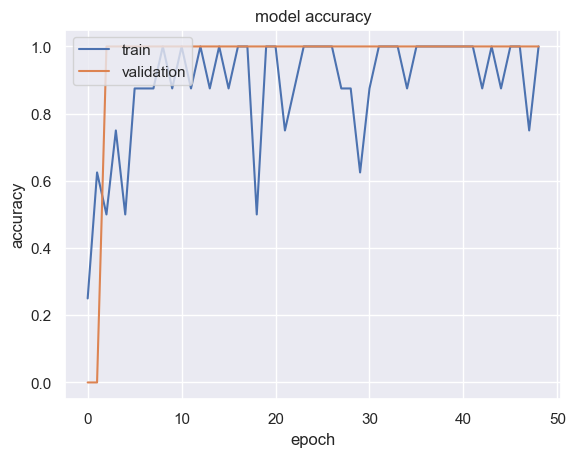

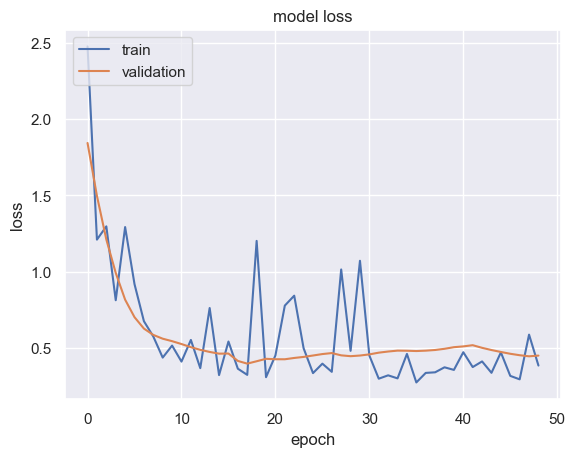

<AxesSubplot: >

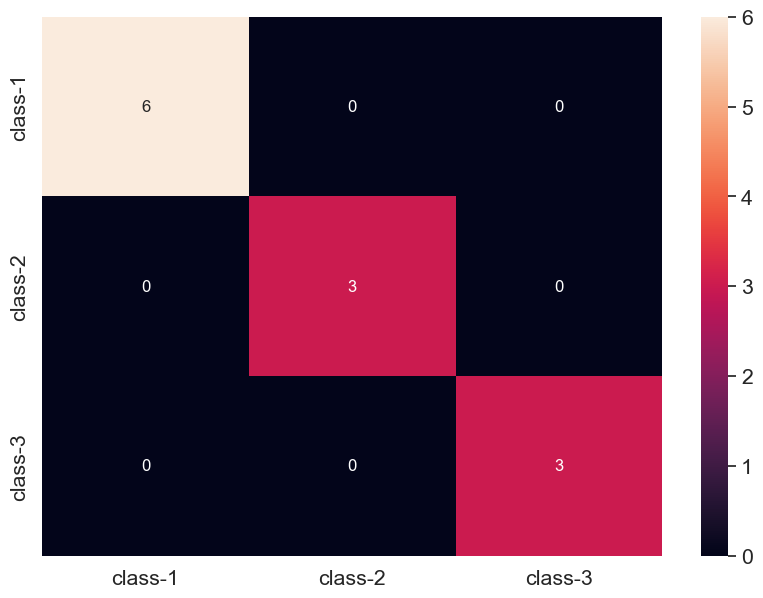

In [2]:
IMG_SIZE=256
#load data
data_X=np.load('data_X_combined.npy')
data_Y=np.load('data_Y_combined.npy')
onehot_encoded=np.load('onehot_encoded_combined.npy')

def rgb2gray(rgb):
    r, g, b = rgb[:,:,0:1], rgb[:,:,1:2], rgb[:,:,2:3]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

Cum=[]


for i in range(len(data_X)):
    Im=[]
    for j in range(data_X.shape[2]):
        img=plt.imread('images_combined\im'+str(i)+'_'+str(j)+'.jpg')
        im=img[50:1050,150:1500,:]  #crop image
        im=cv2.resize(im,(IMG_SIZE,IMG_SIZE))
        im=np.expand_dims(im,axis=-1)
        Im.append(im)

    Im=np.concatenate(Im,axis=-1)
    Cum.append(Im)

    #print progress on same line
    print("Progress: ", i, "/", len(data_X), end="\r")

Cum=np.array(Cum)
#normalize data
Cum=Cum/255.

#get sum along axis=4
Cum=np.sum(Cum,axis=4)


#get first three channels
Cum=Cum[:,:,:,0:3]

print("Image data shape: ", Cum.shape)
#split data into train, validation, and test sets in percentage 70,20,10
X_train, X_test, y_train, y_test = train_test_split(Cum, onehot_encoded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.33, random_state=42)
print("X_train shape: ", X_train.shape)
print("X_val shape: ", X_val.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_val shape: ", y_val.shape)
print("y_test shape: ", y_test.shape)


BATCH_SIZE = 4
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 50
IMAGE_SIZE=256
NUM_CLASSES=y_train.shape[1]



tries=20
check_acc=[]
loss_histories=[]
val_loss_histories=[]
acc_histories=[]
val_acc_histories=[]
y_pred_bool_collect=[]
y_ref_bool_collect=[]

for trying in range(tries):
    print('try number: ', trying)
 # transfer learning strategy----------------------------------------------------------
    base_model = keras.applications.Xception(
        weights='imagenet',  # Load weights pre-trained on ImageNet.
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, Cum.shape[-1]),
        include_top=False)

    base_model.trainable = False
    base_model.layers.pop()

    inputs = keras.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3))
    x = base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x= BatchNormalization()(x)
    x=Dense(20,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
    x=Activation('relu')(x)
    x= BatchNormalization()(x)
    x= Dropout(0.6)(x)
    x= Dense(NUM_CLASSES)(x)
    outputs=Activation('softmax')(x)
    model = keras.Model(inputs, outputs)
    #-------------------------------------------------------------------------------------

    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(1e-3),
                metrics=['accuracy'])

    #train model
    history = model.fit(X_train, y_train, epochs=int(1/3*EPOCHS),batch_size=BATCH_SIZE, validation_data=(X_val, y_val),verbose=0)


    acc1 = history.history['accuracy']
    val_acc1= history.history['val_accuracy']
    loss1 = history.history['loss']
    val_loss1 = history.history['val_loss']
    base_model.trainable = True

    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(1e-5),
                metrics=['accuracy'])

    #train model
    history = model.fit(X_train, y_train, epochs=int(2/3*EPOCHS),batch_size=BATCH_SIZE, validation_data=(X_val, y_val),verbose=0)


    acc2 = history.history['accuracy']
    val_acc2 = history.history['val_accuracy']


    loss2 = history.history['loss']
    val_loss2 = history.history['val_loss']


    acc = acc1+acc2
    val_acc = val_acc1+val_acc2


    loss = loss1+loss2
    val_loss = val_loss1+val_loss2

    acc_histories.append(acc)
    val_acc_histories.append(val_acc)
    loss_histories.append(loss)
    val_loss_histories.append(val_loss)
   
    l,a=model.evaluate(Cum, onehot_encoded, verbose=0)
    y_pred = model.predict(Cum, verbose=0)
    y_pred_bool = np.argmax(y_pred, axis=1)
    y_ref_bool=np.argmax(onehot_encoded, axis=1)
    y_pred_bool_collect.append(y_pred_bool)
    y_ref_bool_collect.append(y_ref_bool)
    check_acc.append(a)



#find argmax of check_acc
ind_max_acc=np.argmax(check_acc)
print("-----------------------------------------")
print("Best accuracy: ", check_acc[ind_max_acc])
print("------------------------------------------")

accuracy=acc_histories[ind_max_acc]
val_accuracy=val_acc_histories[ind_max_acc]
loss=loss_histories[ind_max_acc]
val_loss=val_loss_histories[ind_max_acc]



#plot accuracy and loss
sns.set_theme(style="darkgrid")
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(loss)   
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()



y_pred_bool=y_pred_bool_collect[ind_max_acc]
y_ref_bool=y_ref_bool_collect[ind_max_acc]


cm=confusion_matrix(y_ref_bool,y_pred_bool)


label_names=['class-1','class-2','class-3']

df_cm = pd.DataFrame(cm, label_names,label_names)
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12}) # font size

